# Create Training Data

This notebook is modified from Programming Historian lesson. The high-level purpose is to take a pickled array of htids and discover all the pages marked with IMAGE_ON_PAGE, returning a dict.

In [1]:
import json
import matplotlib.pyplot as plt
import os
import pickle
from random import sample, seed
import time

In [2]:
# Import the HT Data API wrapper and non-versioned keys
from hathitrust_api import DataAPI
from keys import ht_keys

# Replace placeholder strings with your HT credentials (leaving the quote marks)
ht_access_key = ht_keys['access']
ht_secret_key = ht_keys['secret']

# instantiate the Data API connection object
data_api = DataAPI(ht_access_key, ht_secret_key)

In [15]:
# file generated by sample_from_ids.py
sample_path = "sample_ids_1800_1850.pkl"

# we want to get all the image page candidates for the volumes in vol_ids
with open(sample_path, "rb") as fp:
    vol_ids = pickle.load(fp)

In [79]:
# sanitize the id for the training data (can always get it back)
def sanitize_id(unsafe_id):
    """htids contain impermissible characters that can't be used as directory names. Mapping gets rid of colon, forward slash, and period
    ':' --> '+'
    '/' --> '='
    Following: https://github.com/dbamman/jcdl2017/blob/master/data/fiction.txt
    """
    safe_id = unsafe_id.replace(":","+")
    safe_id = safe_id.replace("/","=")
    return safe_id


def unsanitize_id(safe_id):
    """gives back the original HT id"""
    original_id = safe_id.replace('+', ':')
    original_id = original_id.replace('=', '/')
    return original_id

In [80]:
def ht_tuple_download(page_tuples, out_dir=None):
    """
    :param page_tuples: array of (htid, page_num) pairs
    :param out_dir: destination for images; if None, no download
    
    Note: if supplied, out_dir must be an existing directory and
    the caller must have write permissions in that directory
    
    :rtype True on success, False on failure
    """
    
    # if out_dir is not None, then also download page images
    if out_dir:
        
        total_pages = len(page_tuples)
        
        for i, pair in enumerate(page_tuples):
            
            item_id, page = pair[0], pair[1]
            safe_id= sanitize_id(item_id)
            
            try:
                # simple status message
                print("[{}] Downloading page {} ({}/{})".format(item_id, page, i+1, total_pages))
                
                img = data_api.getpageimage(item_id, page)
                img_name = safe_id + "_" + str(page) + ".jpg"               
                img_out = os.path.join(out_dir, img_name)
                
                # skip completed downloads
                if os.path.isfile(img_out):
                    continue
                
                with open(img_out, 'wb') as fp:
                    fp.write(img)

                time.sleep(2)

            except Exception as e:
                print("[{}] Error downloading page {}: {}".format(item_id, page, e))
                
    # return True on success
    return True

In [17]:
def ht_picture_locate(item_id):
    """
    :param item_id: unique HathiTrust volume identifier
    
    :rtype list of all IMAGE_ON_PAGE candidates for item_id
    """
    
    # metadata from API in json format (different than HT collection metadata)
    meta = json.loads(data_api.getmeta(item_id, json=True))

    # sequence gets us each page of the PDF in order, with any
    # additional information that might be available for it
    sequence = meta['htd:seqmap'][0]['htd:seq']

    # list of pages with pictures (empty to start)
    img_pages = []

    # try/except block handles situation where no "pfeats" exist OR
    # the sequence numbers are not numeric
    for page in sequence:
        try:
            if 'IMAGE_ON_PAGE' in page['htd:pfeat']:
                img_pages.append(int(page['pseq']))
        except (KeyError, TypeError) as e:
            continue
        
    # track for download progress report
    total_pages = len(img_pages)
                
    # return the list of image pages
    return img_pages

In [23]:
# Dictionary that maps ids to list of page candidates
pdict = {}
count = 0
total = len(vol_ids)

for item_id in vol_ids:
    pdict[item_id] = ht_picture_locate(item_id)
    
    # don't max out the API
    count += 1
    time.sleep(2)
    
    # occasional update
    if count % 20 == 0:
        print("{}/{}".format(count,total))    

20/2401
40/2401
60/2401
80/2401
100/2401
120/2401
140/2401
160/2401
180/2401
200/2401
220/2401
240/2401
260/2401
280/2401
300/2401
320/2401
340/2401
360/2401
380/2401
400/2401
420/2401
440/2401
460/2401
480/2401
500/2401
520/2401
540/2401
560/2401
580/2401
600/2401
620/2401
640/2401
660/2401
680/2401
700/2401
720/2401
740/2401
760/2401
780/2401
800/2401
820/2401
840/2401
860/2401
880/2401
900/2401
920/2401
940/2401
960/2401
980/2401
1000/2401
1020/2401
1040/2401
1060/2401
1080/2401
1100/2401
1120/2401
1140/2401
1160/2401
1180/2401
1200/2401
1220/2401
1240/2401
1260/2401
1280/2401
1300/2401
1320/2401
1340/2401
1360/2401
1380/2401
1400/2401
1420/2401
1440/2401
1460/2401
1480/2401
1500/2401
1520/2401
1540/2401
1560/2401
1580/2401
1600/2401
1620/2401
1640/2401
1660/2401
1680/2401
1700/2401
1720/2401
1740/2401
1760/2401
1780/2401
1800/2401
1820/2401
1840/2401
1860/2401
1880/2401
1900/2401
1920/2401
1940/2401
1960/2401
1980/2401
2000/2401
2020/2401
2040/2401
2060/2401
2080/2401
2100/2401
212

In [25]:
# test by writing to a file
with open("sample_pages.json", "w") as fp:
    json.dump(pdict, fp, sort_keys=True, indent=4)

(array([708., 557., 236., 111.,  73.,  66.,  35.,  40.,  23.,  27.,  19.,
         19.,  10.,  13.,  12.,  16.,  14.,  13.,  11.,   6.,   5.,   6.,
          4.,   6.,   2.,   2.,   5.,   2.,   3.,   1.,   4.,   4.,   4.,
          4.,   0.,   1.,   0.,   2.,   3.,   5.,   4.,   1.,   1.,   4.,
          0.,   2.,   2.,   0.,   0.,   0.,   0.,   3.,   2.,   0.,   1.,
          0.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.]),
 array([  1.  ,   5.99,  10.98,  15.97,  20.96,  25.95,  30.94,  35.93,
         40.92,  45.91,  50.9 ,  55.89,  60.88,  65.87,  70.86,  75.85,
         80.84,  85.83,  90.82,  95.81, 100.8 , 105.79, 110.78, 115.77,
        120.76, 125.75, 130.74, 135.73, 140.72, 145.71, 150.7 , 155.69,
        160.68, 165.67, 170.66

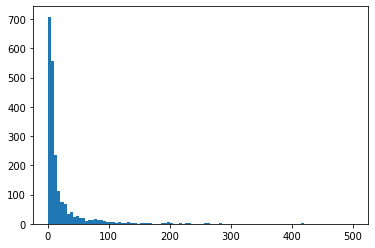

In [42]:
# histogram of number of page candidates per volume
counts = [len(pgs) for pgs in pdict.values()]
plt.hist(counts, bins=100, range=[1,500])

# conlusion: we can sample randomly from this because the heavily-illustrated books don't dominate

In [46]:
# Second stage: randomly sample *pages* from the randomly sampled volumes
all_pages = []
for k,v in pdict.items():
    for p in v:
        all_pages.append((k, p))

In [50]:
N = len(all_pages)

In [51]:
def calculate_sample_size(n):
    # Z table value for 95% confidence interval (normal distribution)
    Z = 1.96
    # probability in population of having attribute (in this case, we could
    # think of half of books being illustrated); assuming 50% gives the
    # maximum variability and is safest assumption
    p = 0.5
    # precision rate of 2%--just using some pretty standard values
    e = 0.02

    # Cochran's formula
    # https://petewarden.com/2017/12/14/how-many-images-do-you-need-to-train-a-neural-network/
    # https://www.checkmarket.com/blog/how-to-estimate-your-population-and-survey-sample-size/
    # https://www.checkmarket.com/sample-size-calculator/
    size = Z**2 * p * (1 - p) / e**2

    # adjust by population size n
    adjusted = size / 1 + ((size - 1) / n)
    return round(adjusted)

In [54]:
n = calculate_sample_size(N)

In [57]:
# always set the same seed!
seed(42)
final_page_sample = sample(all_pages, n)

In [63]:
# save list of tuples of (htid, page_num)
with open("final_page_sample.pkl", "wb") as fp:
    pickle.dump(final_page_sample, fp)

In [81]:
# pass the list of tuples to the function
ht_tuple_download(final_page_sample, out_dir="training_imgs")

[inu.30000080766946] Downloading page 296 (1/2401)
[hvd.32044070613120] Downloading page 584 (2/2401)
[keio.10810914972] Downloading page 66 (3/2401)
[mdp.39015006608916] Downloading page 895 (4/2401)
[wu.89101244978] Downloading page 206 (5/2401)
[mdp.39015074830210] Downloading page 230 (6/2401)
[keio.10811735605] Downloading page 446 (7/2401)
[ucm.5312072733] Downloading page 220 (8/2401)
[mdp.39015006608916] Downloading page 298 (9/2401)
[nnc1.0043506941] Downloading page 618 (10/2401)
[mdp.39015035885303] Downloading page 221 (11/2401)
[mdp.39015006608916] Downloading page 743 (12/2401)
[keio.10811728811] Downloading page 44 (13/2401)
[uc1.$b396750] Downloading page 79 (14/2401)
[uc1.b4036782] Downloading page 24 (15/2401)
[mdp.39015065507827] Downloading page 719 (16/2401)
[keio.10812614089] Downloading page 45 (17/2401)
[uc1.b3007089] Downloading page 439 (18/2401)
[mdp.39015084685885] Downloading page 158 (19/2401)
[keio.10811774309] Downloading page 86 (20/2401)
[nyp.334330682

[mdp.39015067227572] Downloading page 175 (165/2401)
[nyp.33433008043865] Downloading page 158 (166/2401)
[uc1.$b542310] Downloading page 448 (167/2401)
[uc1.$b556037] Downloading page 436 (168/2401)
[mdp.39015031651188] Downloading page 597 (169/2401)
[uc1.b3141487] Downloading page 596 (170/2401)
[hvd.32044070613120] Downloading page 1053 (171/2401)
[umn.31951002719932k] Downloading page 580 (172/2401)
[mdp.35112103404721] Downloading page 414 (173/2401)
[ucm.5306941373] Downloading page 223 (174/2401)
[hvd.hwrmpi] Downloading page 1 (175/2401)
[mdp.39015039356798] Downloading page 45 (176/2401)
[njp.32101066088525] Downloading page 334 (177/2401)
[njp.32101072892928] Downloading page 469 (178/2401)
[hvd.32044070613120] Downloading page 631 (179/2401)
[ucm.5322957687] Downloading page 1 (180/2401)
[uc1.b3032242] Downloading page 348 (181/2401)
[nnc1.cu50767143] Downloading page 94 (182/2401)
[chi.25757844] Downloading page 511 (183/2401)
[osu.32435055146864] Downloading page 211 (184

[pst.000006297824] Downloading page 124 (328/2401)
[njp.32101056301979] Downloading page 794 (329/2401)
[hvd.32044014262166] Downloading page 203 (330/2401)
[osu.32435008969388] Downloading page 144 (331/2401)
[hvd.hwsgix] Downloading page 897 (332/2401)
[hvd.hwp697] Downloading page 312 (333/2401)
[hvd.32044085118750] Downloading page 547 (334/2401)
[hvd.32044092717123] Downloading page 1 (335/2401)
[keio.10812527569] Downloading page 6 (336/2401)
[keio.10812691067] Downloading page 62 (337/2401)
[nyp.33433067293070] Downloading page 387 (338/2401)
[uc1.b4185160] Downloading page 369 (339/2401)
[keio.10811116514] Downloading page 130 (340/2401)
[uc1.31175035601502] Downloading page 3 (341/2401)
[nyp.33433006641660] Downloading page 296 (342/2401)
[pst.000059687399] Downloading page 224 (343/2401)
[osu.32437122053438] Downloading page 23 (344/2401)
[hvd.32044079788063] Downloading page 7 (345/2401)
[mdp.39015065507827] Downloading page 849 (346/2401)
[uiug.30112001328969] Downloading p

[uc1.$b618704] Downloading page 1 (490/2401)
[nnc1.50211070] Downloading page 616 (491/2401)
[uiug.30112087545379] Downloading page 372 (492/2401)
[nnc1.cu51468166] Downloading page 149 (493/2401)
[ien.35556007419591] Downloading page 524 (494/2401)
[nyp.33433071356715] Downloading page 10 (495/2401)
[wu.89030559041] Downloading page 417 (496/2401)
[hvd.hnjvjq] Downloading page 2 (497/2401)
[chi.084728397] Downloading page 221 (498/2401)
[uiug.30112118414355] Downloading page 348 (499/2401)
[nnc1.0043506941] Downloading page 690 (500/2401)
[nyp.33433069144503] Downloading page 457 (501/2401)
[hvd.ah6igy] Downloading page 401 (502/2401)
[pst.000023997370] Downloading page 194 (503/2401)
[osu.32435008969388] Downloading page 123 (504/2401)
[hvd.32044013535653] Downloading page 790 (505/2401)
[ucm.5306941373] Downloading page 30 (506/2401)
[hvd.32044021094602] Downloading page 118 (507/2401)
[njp.32101066872605] Downloading page 38 (508/2401)
[njp.32101068915329] Downloading page 35 (509/

[ucm.5306941373] Downloading page 270 (652/2401)
[hvd.32044106401441] Downloading page 417 (653/2401)
[hvd.hn22x6] Downloading page 153 (654/2401)
[uiug.30112053020472] Downloading page 216 (655/2401)
[nnc1.0035684763] Downloading page 432 (656/2401)
[mdp.39015036018417] Downloading page 664 (657/2401)
[uc1.b3146277] Downloading page 413 (658/2401)
[umn.31951000737191e] Downloading page 181 (659/2401)
[keio.10810914972] Downloading page 2 (660/2401)
[nyp.33433082335245] Downloading page 457 (661/2401)
[mdp.39015074830210] Downloading page 223 (662/2401)
[ucm.5320613859] Downloading page 178 (663/2401)
[hvd.hxj8l6] Downloading page 178 (664/2401)
[mdp.39015039356798] Downloading page 19 (665/2401)
[nyp.33433082488663] Downloading page 442 (666/2401)
[mdp.39015070869428] Downloading page 648 (667/2401)
[mdp.39015012967462] Downloading page 139 (668/2401)
[hvd.32044100881572] Downloading page 174 (669/2401)
[pst.000020043599] Downloading page 933 (670/2401)
[mdp.39015010732934] Downloadin

[nyp.33433061805317] Downloading page 235 (815/2401)
[chi.48434117] Downloading page 276 (816/2401)
[nyp.33433066640248] Downloading page 293 (817/2401)
[nnc1.cu05381037] Downloading page 225 (818/2401)
[nyp.33433067293070] Downloading page 459 (819/2401)
[mdp.39015027424889] Downloading page 60 (820/2401)
[pst.000006297824] Downloading page 16 (821/2401)
[mdp.39015065507827] Downloading page 681 (822/2401)
[nyp.33433008043865] Downloading page 825 (823/2401)
[nyp.33433109936314] Downloading page 1 (824/2401)
[nyp.33433074971510] Downloading page 50 (825/2401)
[hvd.hngf5y] Downloading page 210 (826/2401)
[nyp.33433068255334] Downloading page 500 (827/2401)
[hvd.hnkz89] Downloading page 299 (828/2401)
[hvd.hn1nkg] Downloading page 299 (829/2401)
[nyp.33433069144503] Downloading page 207 (830/2401)
[hvd.hwsq7n] Downloading page 400 (831/2401)
[umn.319510007470849] Downloading page 234 (832/2401)
[mdp.39015031427597] Downloading page 277 (833/2401)
[ucm.5324051953] Downloading page 5 (834

[uiug.30112118414355] Downloading page 128 (979/2401)
[njp.32101073456640] Downloading page 556 (980/2401)
[mdp.39015069429879] Downloading page 465 (981/2401)
[chi.086549650] Downloading page 52 (982/2401)
[uc1.$b542310] Downloading page 478 (983/2401)
[nyp.33433075781058] Downloading page 1 (984/2401)
[nnc1.cu04210590] Downloading page 113 (985/2401)
[mdp.39015065507827] Downloading page 1290 (986/2401)
[chi.22132556] Downloading page 1 (987/2401)
[uiug.30112084423992] Downloading page 304 (988/2401)
[keio.10811061124] Downloading page 141 (989/2401)
[nyp.33433069144503] Downloading page 331 (990/2401)
[uva.x030709349] Downloading page 163 (991/2401)
[chi.25757844] Downloading page 512 (992/2401)
[hvd.32044098656226] Downloading page 44 (993/2401)
[njp.32101066462019] Downloading page 180 (994/2401)
[nyp.33433008043865] Downloading page 157 (995/2401)
[hvd.32044050661032] Downloading page 83 (996/2401)
[hvd.32044070613120] Downloading page 1688 (997/2401)
[hvd.32044067913368] Downloa

[umn.319510007478958] Downloading page 571 (1138/2401)
[nnc1.cu12849162] Downloading page 122 (1139/2401)
[mdp.39015035450652] Downloading page 649 (1140/2401)
[hvd.32044081769838] Downloading page 88 (1141/2401)
[keio.10811670279] Downloading page 39 (1142/2401)
[mdp.39015061027812] Downloading page 706 (1143/2401)
[nnc1.cu05846064] Downloading page 701 (1144/2401)
[keio.10812732588] Downloading page 6 (1145/2401)
[uva.x030801517] Downloading page 273 (1146/2401)
[hvd.32044098656226] Downloading page 584 (1147/2401)
[hvd.hx51rt] Downloading page 1 (1148/2401)
[hvd.hwjlph] Downloading page 160 (1149/2401)
[mdp.39015039629400] Downloading page 275 (1150/2401)
[mdp.39015035450652] Downloading page 197 (1151/2401)
[uva.x030409005] Downloading page 539 (1152/2401)
[nyp.33433062732544] Downloading page 540 (1153/2401)
[ien.35556007419591] Downloading page 372 (1154/2401)
[mdp.39015082298731] Downloading page 6 (1155/2401)
[mdp.39015006608916] Downloading page 43 (1156/2401)
[pst.00006879069

[uc1.$b542310] Downloading page 210 (1298/2401)
[nnc1.cu05381037] Downloading page 557 (1299/2401)
[chi.086191172] Downloading page 46 (1300/2401)
[nyp.33433067293070] Downloading page 19 (1301/2401)
[mdp.39015070869428] Downloading page 532 (1302/2401)
[ucm.531319012x] Downloading page 48 (1303/2401)
[hvd.32044098646359] Downloading page 2 (1304/2401)
[uiug.30112001328969] Downloading page 575 (1305/2401)
[njp.32101066872605] Downloading page 437 (1306/2401)
[pst.000020043599] Downloading page 138 (1307/2401)
[uc1.31158003280756] Downloading page 396 (1308/2401)
[hvd.hx1c1r] Downloading page 551 (1309/2401)
[keio.10812801865] Downloading page 75 (1310/2401)
[ucm.532014245x] Downloading page 64 (1311/2401)
[nyp.33433005893361] Downloading page 208 (1312/2401)
[uc1.b3319905] Downloading page 56 (1313/2401)
[nyp.33433069358392] Downloading page 1 (1314/2401)
[uc1.$b691529] Downloading page 2 (1315/2401)
[nyp.33433067293070] Downloading page 720 (1316/2401)
[uc1.$c146850] Downloading page

[uc1.31175002460858] Downloading page 141 (1456/2401)
[uc1.$b598295] Downloading page 103 (1457/2401)
[nyp.33433082408299] Downloading page 210 (1458/2401)
[nyp.33433069144503] Downloading page 365 (1459/2401)
[keio.10811774309] Downloading page 110 (1460/2401)
[umn.31951002137889z] Downloading page 1 (1461/2401)
[ucm.5325067851] Downloading page 171 (1462/2401)
[nyp.33433075935027] Downloading page 99 (1463/2401)
[chi.084728397] Downloading page 300 (1464/2401)
[hvd.32044005032537] Downloading page 350 (1465/2401)
[pst.000006297824] Downloading page 257 (1466/2401)
[uva.x000856284] Downloading page 200 (1467/2401)
[uc1.$c190097] Downloading page 277 (1468/2401)
[njp.32101071960676] Downloading page 228 (1469/2401)
[mdp.39015031651188] Downloading page 756 (1470/2401)
[nyp.33433082434709] Downloading page 282 (1471/2401)
[hvd.32044046686788] Downloading page 84 (1472/2401)
[mdp.39015074764682] Downloading page 378 (1473/2401)
[uc1.$b247277] Downloading page 411 (1474/2401)
[mdp.3901503

[hvd.32044080041411] Downloading page 109 (1615/2401)
[hvd.hxkbyb] Downloading page 241 (1616/2401)
[uc1.$b285918] Downloading page 179 (1617/2401)
[mdp.39015074715932] Downloading page 98 (1618/2401)
[hvd.hn5f2g] Downloading page 296 (1619/2401)
[uc1.$c190097] Downloading page 86 (1620/2401)
[uc1.b3005311] Downloading page 73 (1621/2401)
[keio.10812695070] Downloading page 68 (1622/2401)
[hvd.32044068920826] Downloading page 742 (1623/2401)
[hvd.32044069556561] Downloading page 75 (1624/2401)
[hvd.32044018855833] Downloading page 153 (1625/2401)
[hvd.hl14wd] Downloading page 1 (1626/2401)
[umn.31951000737191e] Downloading page 269 (1627/2401)
[uc1.$b285918] Downloading page 326 (1628/2401)
[hvd.hn3dex] Downloading page 226 (1629/2401)
[osu.32435055146864] Downloading page 23 (1630/2401)
[hvd.hwpb1u] Downloading page 996 (1631/2401)
[hvd.hx3bgu] Downloading page 1114 (1632/2401)
[hvd.32044098672199] Downloading page 808 (1633/2401)
[hvd.hwjlph] Downloading page 206 (1634/2401)
[chi.084

[hvd.32044070613120] Downloading page 114 (1775/2401)
[nyp.33433069144503] Downloading page 218 (1776/2401)
[hvd.32044010027902] Downloading page 455 (1777/2401)
[inu.30000080764982] Downloading page 467 (1778/2401)
[hvd.32044070613120] Downloading page 1081 (1779/2401)
[nnc1.cu05381037] Downloading page 519 (1780/2401)
[mdp.39015027424889] Downloading page 214 (1781/2401)
[pst.000020043599] Downloading page 571 (1782/2401)
[umn.31951000748768a] Downloading page 195 (1783/2401)
[ucm.5322813707] Downloading page 39 (1784/2401)
[hvd.32044012622197] Downloading page 246 (1785/2401)
[uc1.$c190097] Downloading page 273 (1786/2401)
[keio.10812838610] Downloading page 68 (1787/2401)
[hvd.32044033905449] Downloading page 91 (1788/2401)
[nyp.33433003343930] Downloading page 175 (1789/2401)
[hvd.32044097065882] Downloading page 1 (1790/2401)
[hvd.hnnvzj] Downloading page 99 (1791/2401)
[chi.102709180] Downloading page 275 (1792/2401)
[uc1.b2836965] Downloading page 2 (1793/2401)
[njp.32101071960

[hvd.32044011873189] Downloading page 523 (1934/2401)
[wu.89001036599] Downloading page 457 (1935/2401)
[wu.89052223237] Downloading page 234 (1936/2401)
[hvd.32044070613120] Downloading page 1000 (1937/2401)
[uc1.b5292739] Downloading page 352 (1938/2401)
[ucm.532254680x] Downloading page 3 (1939/2401)
[mdp.39015010732934] Downloading page 555 (1940/2401)
[hvd.hnx8ks] Downloading page 611 (1941/2401)
[nyp.33433069144503] Downloading page 155 (1942/2401)
[nyp.33433069144503] Downloading page 284 (1943/2401)
[mdp.39015062749539] Downloading page 271 (1944/2401)
[ucm.5323254925] Downloading page 179 (1945/2401)
[umn.31951000737191e] Downloading page 422 (1946/2401)
[njp.32101056301979] Downloading page 625 (1947/2401)
[nnc1.0043506941] Downloading page 692 (1948/2401)
[nyp.33433067416226] Downloading page 471 (1949/2401)
[njp.32101074860535] Downloading page 485 (1950/2401)
[coo.31924092896350] Downloading page 1 (1951/2401)
[nyp.33433019779143] Downloading page 299 (1952/2401)
[uc1.$b54

[hvd.hngf5y] Downloading page 12 (2093/2401)
[nyp.33433066619580] Downloading page 653 (2094/2401)
[nyp.33433071379964] Downloading page 421 (2095/2401)
[pst.000023997356] Downloading page 97 (2096/2401)
[mdp.39015043596033] Downloading page 438 (2097/2401)
[uc1.31822043033026] Downloading page 276 (2098/2401)
[uc1.$c190097] Downloading page 167 (2099/2401)
[hvd.hwsgix] Downloading page 1057 (2100/2401)
[keio.10812792289] Downloading page 108 (2101/2401)
[umn.31951000748768a] Downloading page 246 (2102/2401)
[ucm.5324973403] Downloading page 36 (2103/2401)
[hvd.32044021094602] Downloading page 168 (2104/2401)
[chi.103279382] Downloading page 4 (2105/2401)
[nyp.33433062645910] Downloading page 305 (2106/2401)
[uc1.$b285918] Downloading page 272 (2107/2401)
[nnc1.0043506941] Downloading page 45 (2108/2401)
[njp.32101063854887] Downloading page 720 (2109/2401)
[hvd.hwjlph] Downloading page 66 (2110/2401)
[mdp.39015006608916] Downloading page 442 (2111/2401)
[mdp.39015085862715] Downloadin

[njp.32101066872605] Downloading page 564 (2253/2401)
[pst.000020043599] Downloading page 25 (2254/2401)
[mdp.39015065507827] Downloading page 98 (2255/2401)
[wu.89099636409] Downloading page 174 (2256/2401)
[uiug.30112118414355] Downloading page 156 (2257/2401)
[uiug.30112118414355] Downloading page 536 (2258/2401)
[nyp.33433081728986] Downloading page 17 (2259/2401)
[umn.319510008843223] Downloading page 43 (2260/2401)
[mdp.39015068197238] Downloading page 475 (2261/2401)
[mdp.39015085862715] Downloading page 97 (2262/2401)
[uva.x000949976] Downloading page 96 (2263/2401)
[uc1.$b285918] Downloading page 117 (2264/2401)
[hvd.hxihz4] Downloading page 4 (2265/2401)
[uc1.b3005311] Downloading page 46 (2266/2401)
[hvd.hngf5y] Downloading page 351 (2267/2401)
[keio.10811116514] Downloading page 132 (2268/2401)
[nyp.33433074971510] Downloading page 8 (2269/2401)
[nyp.33433005893361] Downloading page 169 (2270/2401)
[uc1.31822035070747] Downloading page 22 (2271/2401)
[uc1.$c146850] Download

True